In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!pip install yahoofinancials

In [ ]:
pip install pandas-ta

In [ ]:
!pip install pycaret

In [ ]:
!pip install costcla

In [ ]:
import pandas as pd
from numpy import mean
from datetime import datetime
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
import numpy as np
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from catboost import CatBoostClassifier
from catboost.utils import Pool, get_confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from costcla.metrics import cost_loss, savings_score
from costcla.models import CostSensitiveRandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from xgboost import XGBClassifier, plot_importance, DMatrix, plot_tree
import pandas_ta as ta


In [ ]:
ticker_details = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Ticker List.xlsx')

In [ ]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()
print(names)

In [ ]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= "2020-06-19"
start_date = "2000-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

In [ ]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1', axis=1)

In [ ]:
#Renaming columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
values.columns = names
#print(values.shape)
#print(values.isna().sum())
values.tail()

,Date,SPX,USD Index,VIX,Gold,Oil,Nikkei,Dax,10Yr,2Yr,EEM,High Yield Fund,XLE,XLF,XLI,AUDJPY,XLK,SSE,XLP,XLY,XLU,XLV,Lockheed
5335,2020-06-15,3066.590088,96.680000,34.400002,1731.400024,37.259998,21530.949219,11911.349609,138.406250,110.332031,39.279999,5.65,39.434315,24.006859,69.192810,74.778999,100.094139,NaN,58.335419,126.235977,58.580917,97.407364,373.279999
5336,2020-06-16,3124.739990,96.959999,33.669998,1735.400024,37.810001,22582.210938,12315.660156,138.406250,110.316406,39.529999,5.71,40.569756,24.384451,70.546799,74.057999,102.228264,NaN,59.248302,128.889801,58.848682,99.807198,382.769989
5337,2020-06-17,3113.489990,97.160004,33.470001,1736.900024,37.439999,22455.759766,12382.139648,138.593750,110.324219,39.910000,5.71,39.187481,24.016796,70.039047,73.495003,102.208313,NaN,59.158997,128.550598,58.670174,99.707611,382.109985
5338,2020-06-18,3115.340088,97.419998,32.939999,1729.800049,39.290001,22355.460938,12281.530273,138.671875,110.324219,39.930000,5.70,39.671276,23.986986,69.780197,73.370003,102.667046,NaN,59.466602,128.081680,58.660259,99.369049,378.390015
5339,2020-06-19,NaN,NaN,NaN,NaN,NaN,22478.789062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Front filling the NaN values in the data set
values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
values.isna().sum()

# Co-ercing numeric type to all columns except Date
cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=4)
#print(values.tail())

In [ ]:
values['SPX-RSI'] = ta.rsi( values['SPX'] )

BBANDS = ta.bbands( values['SPX'] )
keys = BBANDS.keys().to_list()

Upper = BBANDS[ 'BBU_5' ]
Lower = BBANDS[ 'BBL_5' ]

Upper_perc = Upper / values['SPX']
Lower_perc = Lower / values['SPX']

values[ 'BBU-Distance' ] = Upper_perc
values[ 'BBL-Distance' ] = Lower_perc
values['MACD-Histogram'] = ta.macd( values[ 'SPX' ] )[ 'MACDH_12_26_9' ]


In [ ]:
imp = ['Gold','USD Index', 'Oil', 'SPX','VIX', 'High Yield Fund' , 'Nikkei', 'Dax', '10Yr', '2Yr' , 'EEM' ,'XLE', 'XLF', 'XLI', 'AUDJPY', 'XLK', 'SSE', 'XLP','XLY', 'XLU', 'XLV', 'Lockheed']
# Calculating Short term -Historical Returns
change_days = [1,3,5,14,21]

data = pd.DataFrame(data=values['Date'])
for i in change_days:
    print(data.shape)
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
#print(data.shape)



In [ ]:
data.ta.macd

In [ ]:
# Calculating Long term Historical Returns
change_days = [60,90,180,250]

for i in change_days:
    print(data.shape)
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
#print(data.shape)

(5340, 111)
(5340, 133)
(5340, 155)
(5340, 177)


In [ ]:
#Calculating Moving averages for SPX
moving_avg = pd.DataFrame(values['Date'],columns=['Date'])
moving_avg['Date']=pd.to_datetime(moving_avg['Date'],format='%Y-%b-%d')
moving_avg['SPX/15SMA'] = (values['SPX']/(values['SPX'].rolling(window=15).mean()))-1
moving_avg['SPX/30SMA'] = (values['SPX']/(values['SPX'].rolling(window=30).mean()))-1
moving_avg['SPX/60SMA'] = (values['SPX']/(values['SPX'].rolling(window=60).mean()))-1
moving_avg['SPX/90SMA'] = (values['SPX']/(values['SPX'].rolling(window=90).mean()))-1
moving_avg['SPX/180SMA'] = (values['SPX']/(values['SPX'].rolling(window=180).mean()))-1
moving_avg['SPX/90EMA'] = (values['SPX']/(values['SPX'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
moving_avg['SPX/180EMA'] = (values['SPX']/(values['SPX'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
moving_avg = moving_avg.dropna(axis=0)
#print(moving_avg.shape)
#print(moving_avg.head())

#Merging Moving Average values to the feature space
#print(data.shape)
data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')
data = pd.merge(left=data,right=moving_avg,how='left',on='Date')
#print(data.shape)
data.isna().sum()

In [ ]:
#Caluculating forward returns for Target
y = pd.DataFrame(data=values['Date'])
print(y.shape)

y['SPX-T+14']=values["SPX"].pct_change(periods=-14)
y['SPX-T+22']=values["SPX"].pct_change(periods=-22)
print(y.shape)
y.isna().sum()
len(names)

(5340, 1)
(5340, 3)


23

In [ ]:
# Removing NAs
print(data.shape)
data = data[data['SPX-T-250'].notna()]
y = y[y['SPX-T+22'].notna()]
print(data.shape)
print(y.shape)



(5340, 206)
(5090, 206)
(5318, 3)


In [ ]:
#Adding Target Variables
data = pd.merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
print(data.shape)
data.isna().sum()



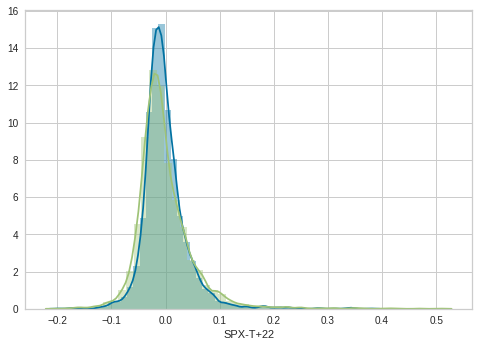

In [ ]:
sns.distplot(data['SPX-T+14'])
sns.distplot(data['SPX-T+22'])

In [ ]:
#Select Threshold p (left tail probability)
p1 = 0.25
p2 = 0.75
#Get z-Value
z1 = st.norm.ppf(p1)
z2 = st.norm.ppf(p2)
print(z1)
print(z2)



-0.6744897501960817
0.6744897501960817


In [ ]:
#Calculating Threshold (t) for each Y
t_141 = round((z1*np.std(data["SPX-T+14"]))+np.mean(data["SPX-T+14"]),5)
t_142 = round((z2*np.std(data["SPX-T+14"]))+np.mean(data["SPX-T+14"]),5)
t_221 = round((z1*np.std(data["SPX-T+22"]))+np.mean(data["SPX-T+22"]),5)
t_222 = round((z2*np.std(data["SPX-T+22"]))+np.mean(data["SPX-T+22"]),5)

In [ ]:
print("t_141=",t_141)
print("t_142=",t_142)
#print("t_221=",t_221)
#print("t_222=",t_222)

t_141= -0.02942
t_142= 0.02636


In [ ]:
#Creating Labels
data['Y-141'] = (data['SPX-T+14']< t_141)*1
data['Y-142'] = (data['SPX-T+14']> t_142)*1
data['Y-221']= (data['SPX-T+22']< t_221)*1
data['Y-222']= (data['SPX-T+22']> t_222)*1
#print("Y-141", sum(data['Y-141']))
#print("Y-142", sum(data['Y-142']))
#print("Y-221", sum(data['Y-221']))
#print("Y-222", sum(data['Y-222']))

data_TEST = data.iloc[: -150]



In [ ]:
data = data.drop(['SPX-T+14','SPX-T+22','Date'],axis=1)
#print(data.head())

In [ ]:
data_14 = data.drop(['Y-221','Y-222','Y-141'],axis=1)
X = data_14.drop(['Y-142','SPX/90EMA','SPX-T-180','High Yield Fund-T-180','SPX-T-90','2Yr-T-90','SPX/180EMA','XLP-T-250','XLE-T-180','XLK-T-180','SPX/180SMA','SPX/90SMA','XLK-T-180','SPX-T-60','SPX-T-21','SPX-T-14','SPX-T-250','SPX-T-5','SPX-T-3','SPX-T-1','XLI-T-90','2Yr-T-180','High Yield Fund-T-250','XLY-T-180','XLI-T-180','SPX/30SMA','XLI-T-250','Dax-T-250','EEM-T-250','XLI-T-14'],axis=1)
y= data_14['Y-142']
feature_names = list(X.columns.values)


In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
pd.set_option("display.max_rows", None)                                                                     

In [ ]:
vif.round(1)

,VIF Factor,features
0,1.9,USD Index-T-1
1,3.3,VIX-T-1
2,1.8,Gold-T-1
3,1.2,Oil-T-1
4,1.8,Nikkei-T-1
5,2.7,Dax-T-1
6,3.3,10Yr-T-1
7,3.2,2Yr-T-1
8,4.5,EEM-T-1
9,2.8,High Yield Fund-T-1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [ ]:
mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

In [ ]:
smt = SMOTETomek()
X_train, y_train = smt.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


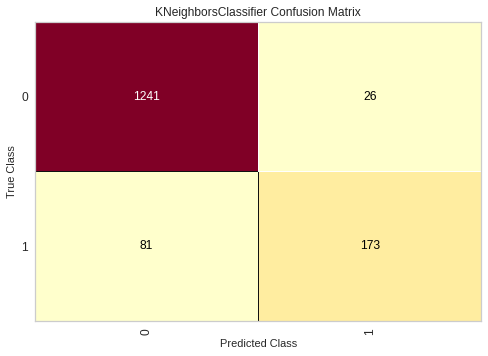

In [ ]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=37, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=1,
                     weights='uniform')
knn.fit(X_train,y_train)
y_pred = knn.predict_proba(X_test)
cm = ConfusionMatrix(knn)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

In [ ]:
k_range = np.arange(1,61)
weights = ["uniform","distance"]
algorithm = ["auto", "ball_tree","kd_tree","brute"]
p = [1,2]
leaf_size_range = np.arange(1,71)
param_grid = dict(n_neighbors = k_range, weights = weights, leaf_size = leaf_size_range,p = p)
knn = KNeighborsClassifier()
randomized = RandomizedSearchCV(knn, param_grid,scoring = "f1", cv = 5, n_iter = 20)
randomized.fit(X_train,y_train)
randomized.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=37, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=1,
                     weights='uniform')

In [ ]:
catb = CatBoostClassifier(iterations=5000,scale_pos_weight=6)
catb.fit(X_train, y_train)
y_pred = catb.predict_proba(X_test)
cm = get_confusion_matrix(catb, Pool(X_test, y_test))
print(cm)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


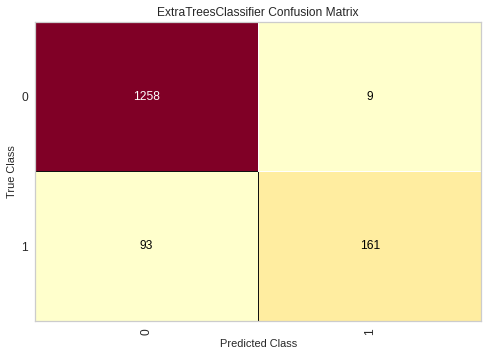

In [ ]:
et = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='entropy',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=117, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)
et.fit(X_train,y_train)
y_pred = et.predict_proba(X_test)
cm = ConfusionMatrix(et)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

In [ ]:
estimator_range = np.arange(1,350)
criterion = ["gini","entropy"]
depth = np.arange(1,100)
features = ["auto","sqrt","log2"]
class_weight = ["balanced", "balanced_subsample"]
leaf_size_range = np.arange(1,71)
param_grid = dict(n_estimators = estimator_range, criterion = criterion, max_features = features, class_weight = class_weight)
et = ExtraTreesClassifier()
randomized = RandomizedSearchCV(et, param_grid,scoring = "f1", cv = 5, n_iter = 20, verbose= True)
randomized.fit(X_train,y_train)
randomized.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.3min finished


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='entropy',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=117, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


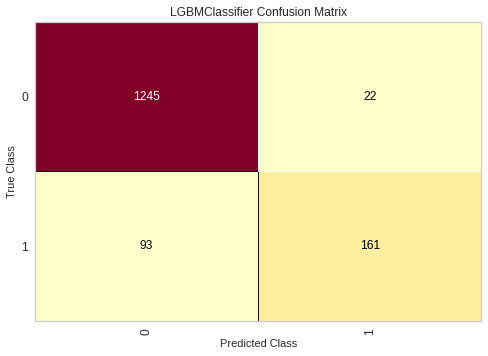

In [ ]:
lgbm = LGBMClassifier(class_weight={0: 6, 1: 1})
lgbm.fit(X_train,y_train)
y_pred = lgbm.predict_proba(X_test)
cm = ConfusionMatrix(lgbm)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

In [ ]:
estimator_range = np.arange(1,350)
boosting = ['gbdt', 'dart']
max_depth = np.arange(15, 50)
n_estimators = np.arange(50 , 150)
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, boosting = boosting, estimator_range = estimator_range)
lgbm = LGBMClassifier(silent = False)
randomized = RandomizedSearchCV(lgbm, param_grid,scoring = "f1", cv = 5, n_iter = 20)
randomized.fit(X_train,y_train)
randomized.best_estimator_

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, estimator_range=203,
               importance_type='split', learning_rate=0.1, max_depth=27,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=126, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
xgb = XGBClassifier( scale_pos_weight = 6,base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, seed=123,
              silent=None, subsample=1, verbosity=1)
xgb_gs.fit(X_train,y_train)
print ("_________________________________Model Selection_____________________________________")
print ("Best estimator found by grid search:",xgb_gs.best_estimator_)
print ("Best parameters found by grid search:",xgb_gs.best_params_)
print ("Best accuracy score found by grid search:",xgb_gs.best_score_)
print ()

________________________________Model Prediction_____________________________________
F1-measure: 0.7888888888888889

-------------------------------------Accuracy-----------------------------------------
Accuracy: 0.9250493096646942
---------------------------------Confusion Matrix-------------------------------------
TP 213
TN 1194
FP 73
FN 41


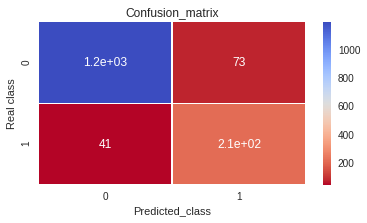


--------------------------------Precession and Recall---------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1267
           1       0.74      0.84      0.79       254

    accuracy                           0.93      1521
   macro avg       0.86      0.89      0.87      1521
weighted avg       0.93      0.93      0.93      1521



In [ ]:
def classifier_measures(y_test,model_pred):
    # output confusion matrix
    print ("-------------------------------------Accuracy-----------------------------------------")
    Accuracy = accuracy_score(y_test, model_pred)
    print ("Accuracy:",Accuracy)
    print ("---------------------------------Confusion Matrix-------------------------------------")
    model_matrix = confusion_matrix(y_test, model_pred)
    # print ('Confusion matrix:\n',model_matrix)
    fig= plt.figure(figsize=(6,3))# to plot the graph
    print("TP",model_matrix[1,1,]) # no of Fraud transaction which are predicted Fraud
    print("TN",model_matrix[0,0]) # no. of normal transaction which are predited normal
    print("FP",model_matrix[0,1]) # no of normal transaction which are predicted Fraud
    print("FN",model_matrix[1,0]) # no of Fraud Transaction which are predicted normal
    sns.heatmap(model_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()

    print()
    print ("--------------------------------Precession and Recall---------------------------------")
    target_names = ['0',"1"]
    print(classification_report(y_test, model_pred, target_names=target_names))

# Predict new values using best model derived from cross validation and test performance on the test set
xgb_pred = xgb_gs.predict(X_test)
xgb_prob = xgb_gs.predict_proba(X_test)
xgb_score = xgb_gs.score(X_test, y_test)
print ("________________________________Model Prediction_____________________________________")
print ('F1-measure:', xgb_score)
print ()
classifier_measures(y_test,xgb_pred)

In [ ]:
classifier1 = KNeighborsClassifier(n_neighbors = 6,weights= 'uniform',p = 2)
classifier2 = LGBMClassifier(class_weight={0: 1, 1: 5})
classifier3 = XGBClassifier( scale_pos_weight = 6,base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, seed=123,
              silent=None, subsample=1, verbosity=1)
classifier4 = CatBoostClassifier(iterations=5000)
classifier5 = ExtraTreesClassifier(class_weight= "balanced", max_features= "log2", n_estimators = 325)

sclf = StackingCVClassifier(classifiers = [classifier1, classifier2, classifier4, classifier5],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = CatBoostClassifier())

classifiers = {"KNN": classifier1,
               "LGBM": classifier2,
               "XGB": classifier3,
               "CatBoost": classifier4,
               "ET": classifier5,
               "Stack": sclf}

# Train classifiers
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(X_train, y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier

pred = sclf.predict( X_test) 



In [ ]:
# Get results
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict(X_test)
    
    # Save results in pandas dataframe object
    results[f"{key}"] = y_pred

# Add the test set to the results object
results["Target"] = y_test

In [ ]:
pred_stack = results[ 'Stack' ] 
score = f1_score( y_test, pred_stack ) 
score

0.7400468384074942

In [ ]:
iterations = np.arange(1,5000)
l2_leaf_reg = np.arange(2,30)

param_grid = dict(iterations = iterations, l2_leaf_reg = l2_leaf_reg)
Stack = CatBoostClassifier()
randomized = RandomizedSearchCV(Stack, param_grid,scoring = "f1", cv = 5, n_iter = 20)
randomized.fit(X_train,y_train)
randomized.best_estimator_

In [ ]:
from sklearn.metrics import confusion_matrix

pred = sclf.predict( X_test ) 

confusion_matrix( y_test, pred ) 

array([[1247,   20],
       [  95,  159]])

In [ ]:
#DONT RUN 
#DONT RUN

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

#mm = MinMaxScaler()
#X_train = mm.fit_transform(X_train)
#X_test = mm.transform(X_test)

#smt = SMOTETomek()
#X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)

#data_train = pd.concat( [ pd.DataFrame( X_train ), pd.DataFrame( y_train ) ], axis = 1 )
#data_train.columns = data_14.columns
#data_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)],axis = 1)
#data_test.columns = data_14.columns
#data_train.head()
#data_test.head()


In [ ]:
!pip install hmmlearn

In [ ]:
!pip install quandl